# Activation Maximization on MNIST

Lets build the mnist model and train it for 5 epochs. It should get to about ~99% test accuracy.

In [1]:
from __future__ import print_function

import os
import numpy as np
import keras
import tensorflow as tf
print(tf.__version__)

from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Input
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 5

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model_path = 'mnist_model.h5'
if os.path.exists(model_path):
    model = keras.models.load_model(model_path)
    model.summary()
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
else:
    
    inputs = Input(shape=(28,28,1))
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.25)(x)
    outputs = Dense(num_classes, activation='softmax', name='preds')(x)
    model = keras.models.Model(inputs=inputs, outputs=outputs)
    
#     model = Sequential()
#     model.add(Conv2D(32, kernel_size=(3, 3),
#                      activation='relu',
#                      input_shape=input_shape))
#     model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))
#     model.add(Flatten())
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(num_classes, activation='softmax', name='preds'))
    model.summary()
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))

    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    model.save(model_path)

Using TensorFlow backend.


1.14.0
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
____________________________________________

## Dense Layer Visualizations

To visualize activation over final dense layer outputs, we need to switch the `softmax` activation out for `linear` since gradient of output node will depend on all the other node activations. Doing this in keras is tricky, so we provide `utils.apply_modifications` to modify network parameters and rebuild the graph.

If this swapping is not done, the results might be suboptimal. We will start by swapping out 'softmax' for 'linear' and compare what happens if we dont do this at the end.

Lets start by visualizing input that maximizes the output of node 0. Hopefully this looks like a 0.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


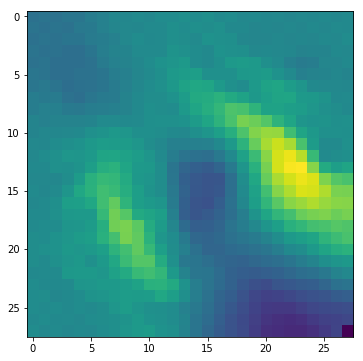

In [2]:
from vis.visualization import visualize_activation
from vis.utils import utils
from keras import activations

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'preds')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

# This is the output node we want to maximize.
filter_idx = 0
img = visualize_activation(model, layer_idx, filter_indices=filter_idx)
plt.imshow(img[..., 0])

Hmm, it sort of looks like a 0, but not as clear as we hoped for. Activation maximization is notorious because regularization parameters needs to be tuned depending on the problem. Lets enumerate all the possible reasons why this didn't work very well.
    
- The input to network is preprocessed to range (0, 1). We should specify `input_range = (0., 1.)` to constrain the input to this range.
- The regularization parameter default weights might be dominating activation maximization loss weight. One way to debug this is to use `verbose=True` and examine individual loss values.

Lets do these step by step and see if we can improve it.

### Debugging step 1: Specifying input_range

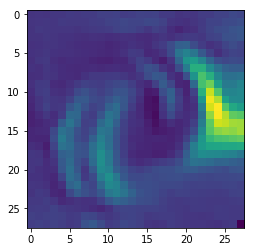

In [3]:
img = visualize_activation(model, layer_idx, filter_indices=filter_idx, input_range=(0., 1.))
plt.imshow(img[..., 0])

Much better but still seems noisy. Lets examining the losses with `verbose=True` and tuning the weights.

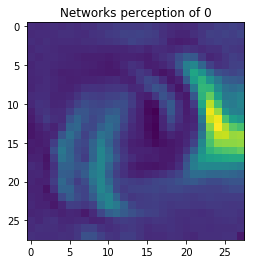

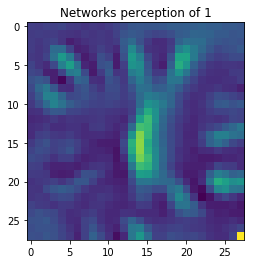

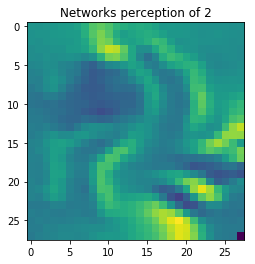

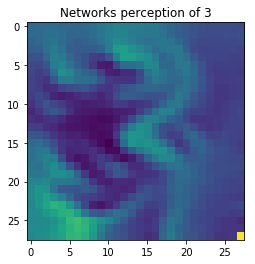

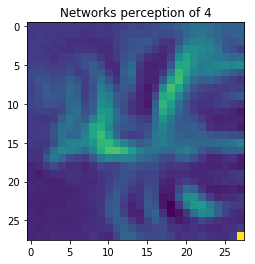

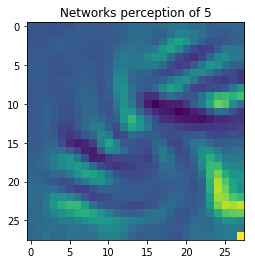

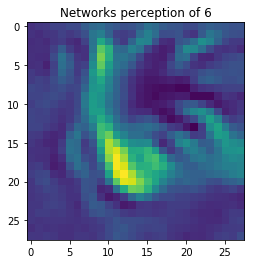

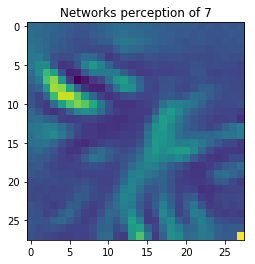

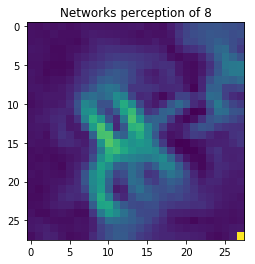

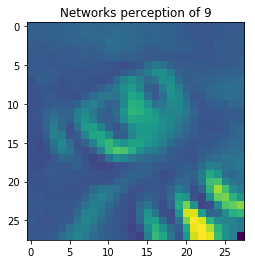

In [7]:
for output_idx in np.arange(10):
    # Lets turn off verbose output this time to avoid clutter and just see the output.
    img = visualize_activation(model, layer_idx, filter_indices=output_idx, input_range=(0., 1.))
    plt.figure()
    plt.title('Networks perception of {}'.format(output_idx))
    plt.imshow(img[..., 0])

Pretty cool. Its amazing that we can even generate an input image via backprop! 

Obviously you can tune the visualizations to look better by experimenting with `image_modifiers`, lp-norm weight etc. Basically, a regularizer is needed to enforce image naturalness prior to limit the input image search space. By this point, GANs should come to your mind. We could easily take a GAN trained on mnist and use discriminator loss as a regularizer. For using custom loss, you can use `visualize_activation_with_losses` API.

Feel free to submit a PR if you try the GAN regularizer :)

## Other fun stuff

The API to `visualize_activation` accepts `filter_indices`. This is generally meant for *multi label* classifiers, but nothing prevents us from having some fun. 

By setting `filter_indices=[1, 7]`, we can generate an input that the network thinks is both 1 and 7 simultaneously. Its like asking the network

> Generate input image that you think is both 1 and a 7.

In [8]:
img = visualize_activation(model, layer_idx, filter_indices=[1, 7], input_range=(0., 1.))
plt.imshow(img[..., 0])

Compare this to the `1` generated above and you should be able to see the difference. Nifty indded!

In [10]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179

In [11]:
from vis.visualization import visualize_activation
layer_idx = utils.find_layer_idx(model, 'dense_1')

model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

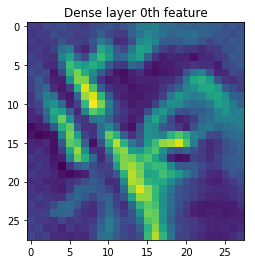

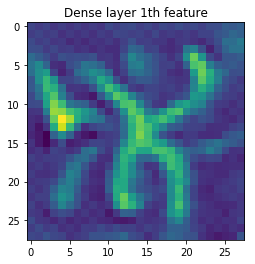

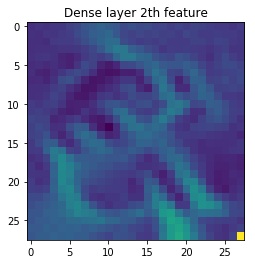

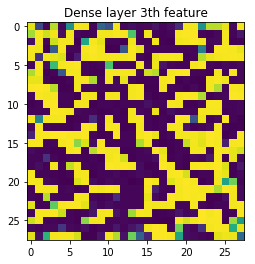

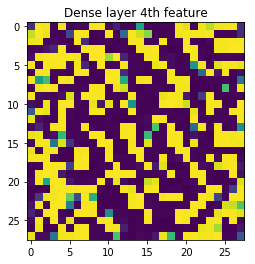

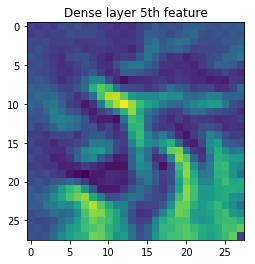

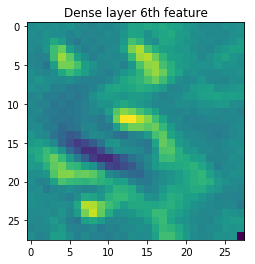

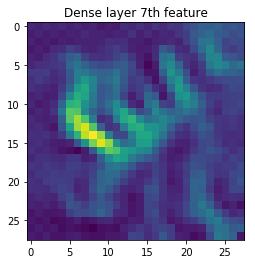

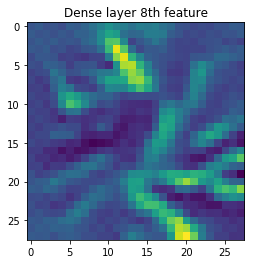

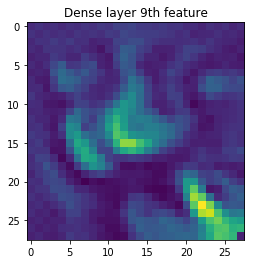

In [12]:
for idx in np.arange(10):
    # Lets turn off verbose output this time to avoid clutter and just see the output.
    img = visualize_activation(model, layer_idx, filter_indices=idx, input_range=(0., 1.))
    plt.figure()
    plt.title('Dense layer {}th feature'.format(idx))
    plt.imshow(img[..., 0])